In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [9]:
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [10]:
from MMM import mmm

# 0. Data Imports

In [11]:
data = pd.read_csv("sales.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]

In [12]:
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,na,28157.000000
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,na,10644.000000
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,na,9597.000000
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,na,90189.000000


# 1. Seasonality and Trend Decomposition

To-do
- Convert to method
- Add Holidays optional holidays functionality

In [13]:
START_INDEX = 52
END_INDEX = 144

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append met

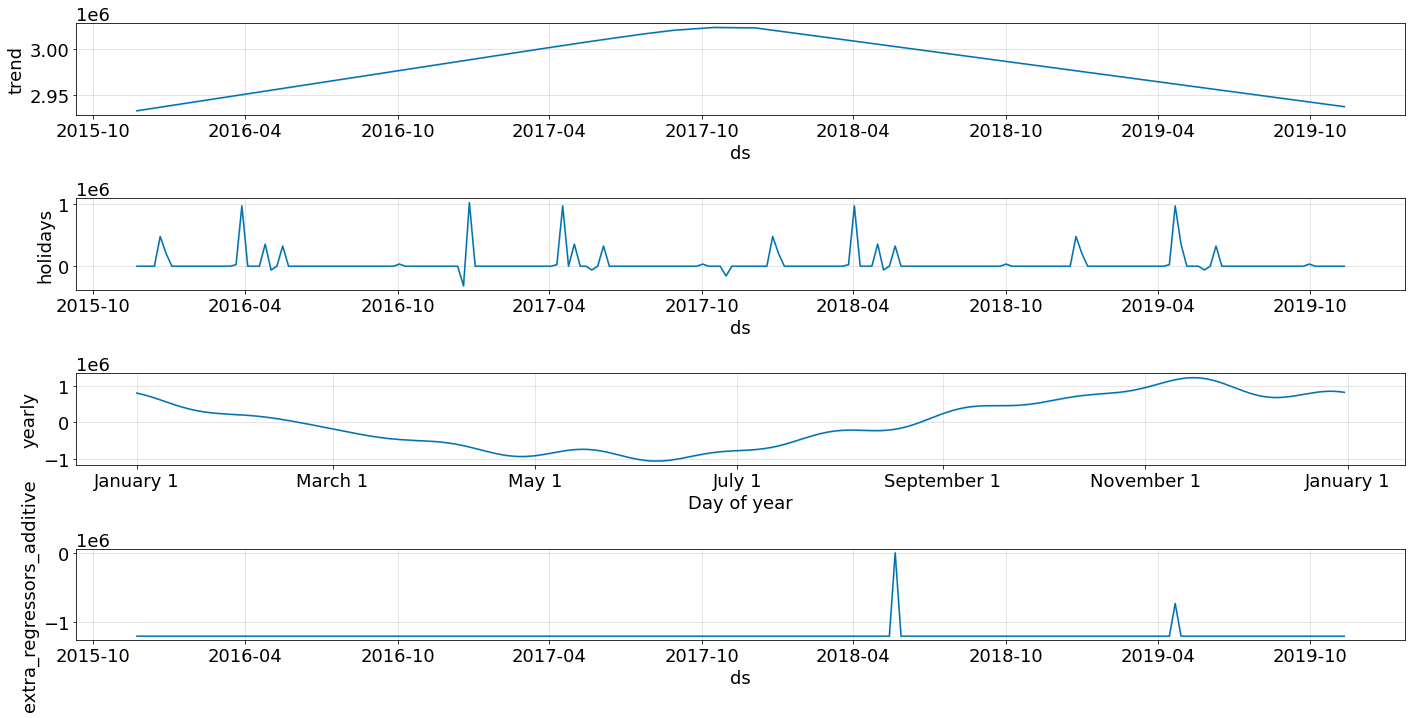

In [14]:
mm_model = mmm()
data = mm_model.decomposition(data, encode_holidays = True, 
                              encode_events = True, 
                              holidays_file = "generated_holidays.csv", 
                              country_code = "DE")
mm_model.plot_decomposition()

# 2. Spend-Exposure estimation

In [15]:
media_spend_exposure_df = mm_model.estimate_spend_exposure(data,
                                                          media_exposures = ["facebook_I", "search_clicks_P"],
                                                          media_spends = ["facebook_S", "search_S"])

# 3. Scaling and Standardization

In [16]:
#choose features/variables to normalize e.g. only independant variables. 
feature_vars = ["trend", 
                "season", 
                "holiday", 
                "competitor_sales_B", 
                "events", 
                "tv_S", 
                "ooh_S", 
                "print_S",
                "facebook_I", 
                "search_clicks_P", 
                "newsletter"]

target_var = "revenue"

def normalize_data(data, feature_vars):
    data_transformed = data.copy()
    numerical_encoder_dict = {}
    
    for feature in feature_vars:
        scaler = MinMaxScaler()
        original = data[feature].values.reshape(-1, 1)
        transformed = scaler.fit_transform(original)
        data_transformed[feature] = transformed
        numerical_encoder_dict[feature] = scaler
        
    return data_transformed

In [17]:
data_transformed = normalize_data(data, feature_vars)
data_transformed[target_var] = data[target_var].values / 100_000

# 4. PYMC3 Model

In [18]:
delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]
control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]

mm_model.initialize(data_transformed, 
                    delay_channels, 
                    media_channels, 
                    control_variables, 
                    target_var, 
                    START_INDEX = 52, 
                    END_INDEX = 144)

Delay Channels: Adding tv_S


INFO:filelock:Lock 140660362438064 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660362438064 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660362843712 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660362843712 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660367803632 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660367803632 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660367891904 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660367891904

Delay Channels: Adding ooh_S


INFO:filelock:Lock 140660407338080 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660407338080 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding print_S


INFO:filelock:Lock 140660425660160 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660425660160 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding facebook_I


INFO:filelock:Lock 140660433599936 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660433599936 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding search_clicks_P


INFO:filelock:Lock 140660432781424 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660432781424 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding newsletter


INFO:filelock:Lock 140660361319664 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660361319664 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


INFO:filelock:Lock 140660444550096 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660444550096 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660437774544 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660437774544 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660444795328 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660444795328 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660445009520 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660445009520

INFO:filelock:Lock 140660454883184 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660454883184 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660454917792 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660454917792 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660455017200 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660455017200 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660454882176 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660454882176

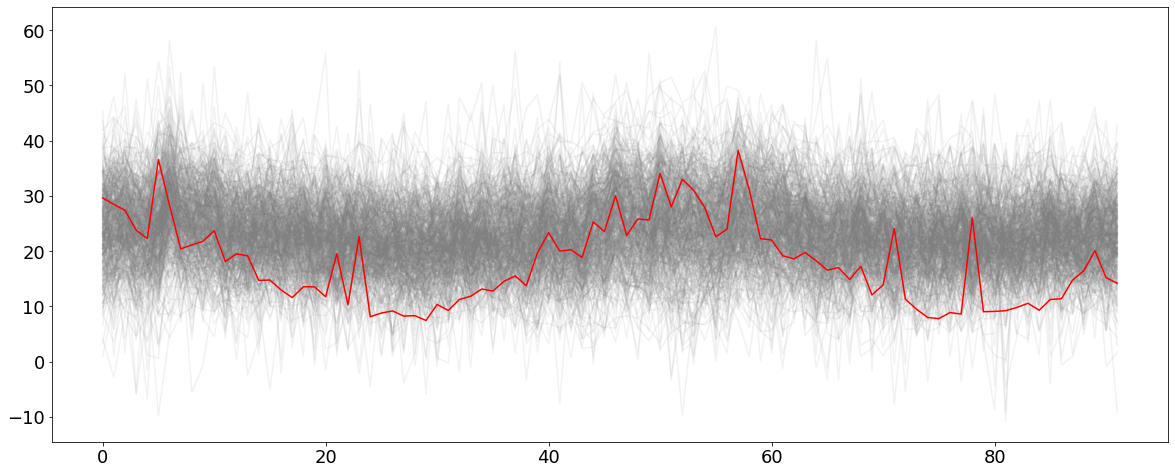

In [19]:
mm_model.plot_prior_predictive(data_transformed)

In [20]:
trace, trace_summary = mm_model.fit(draws = 100,
                                    tune = 100, 
                                    chains = 4, 
                                    cores = 4, 
                                    target_accept = 0.95)

INFO:filelock:Lock 140660432602832 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660432602832 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660482073024 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660482073024 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660482344416 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660482344416 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660477724656 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660477724656

INFO:filelock:Lock 140660118655616 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660118655616 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660119544640 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660119544640 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660119797472 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660119797472 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660130712880 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140660130712880

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 395 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 395 seconds.


In [21]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,-2.848,1.510,-5.546,0.163,0.070,0.053,480.0,313.0,1.01
season_control_coef,8.556,1.713,5.816,11.940,0.064,0.047,720.0,368.0,1.00
holiday_control_coef,11.939,1.396,9.223,14.311,0.068,0.048,420.0,370.0,1.01
competitor_sales_B_control_coef,11.799,1.913,8.190,15.226,0.078,0.056,587.0,305.0,1.00
events_control_coef,9.155,1.888,5.106,12.494,0.080,0.057,549.0,253.0,1.02
intercept,6.180,1.407,3.188,8.870,0.068,0.049,426.0,281.0,1.00
tv_S_adstock,0.301,0.129,0.084,0.536,0.008,0.006,298.0,294.0,1.00
tv_S_gamma,0.275,0.149,0.096,0.558,0.011,0.008,209.0,317.0,1.01
tv_S_alpha,2.760,1.556,0.703,5.903,0.096,0.071,339.0,250.0,1.02
tv_S_media_coef,4.116,1.273,2.067,6.435,0.076,0.056,302.0,316.0,1.00


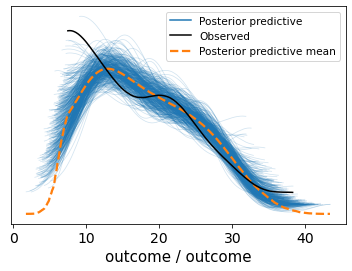

In [29]:
mm_model.plot_posterior_predictive()

In [30]:
mm_model.fit_metrics(data)

RMSE: 179220.00474548028
MAPE: 0.06876779623146727
NRMSE: 0.05816473888412552


# 5. Decomposition

In [31]:
#Apply media transformations on data with optimized parameters.
data_transformed_decomposed = mm_model.apply_transformations(data_transformed)

RMSE: 185739.84486724847
MAPE: 0.06751207617528797
NRMSE: 0.06028071248198057


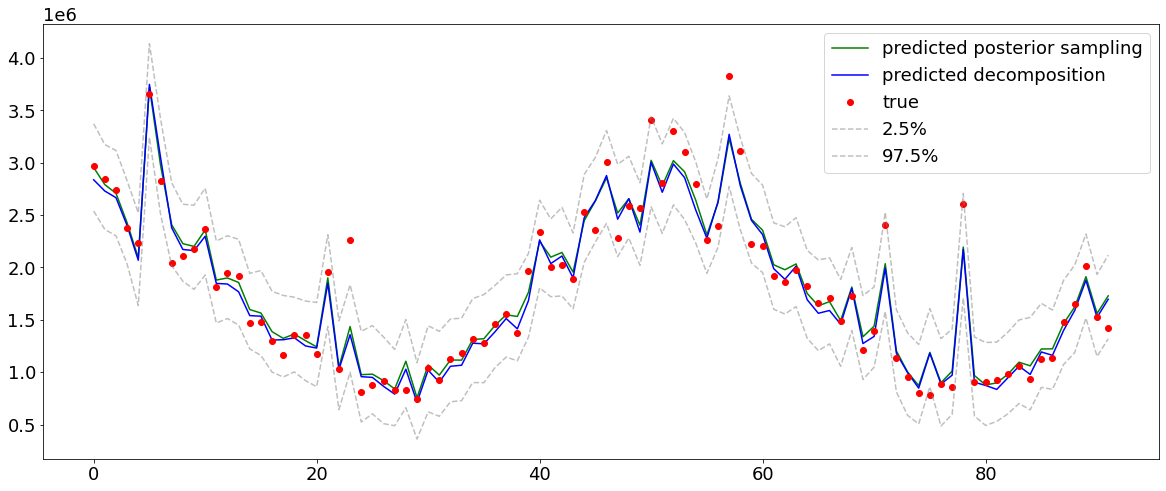

In [32]:
mm_model.plot_model_fit(data_transformed_decomposed)

In [33]:
#Test accuracies
predictions = mm_model.predict(data_transformed_decomposed, 144, 156, return_metrics = True)

RMSE: 167092.01672095433
MAPE: 0.062208320741375646
NRMSE: 0.13112215114501666


In [34]:
spend_response_share_df = mm_model.compute_spend_effect_share(data, data_transformed_decomposed, media_spend_exposure_df)

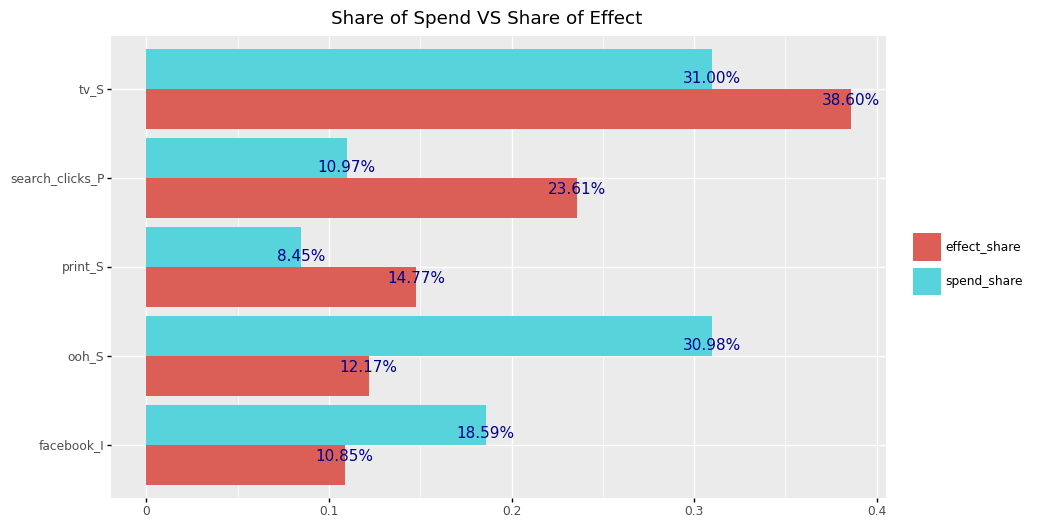

<ggplot: (8791217608006)>

In [35]:
mm_model.plot_spend_vs_effect_share(spend_response_share_df)